In [1]:
from __future__ import unicode_literals, division
import re
import sys
from tqdm import tqdm_notebook

In [2]:
# ! pip install tqdm --user 

In [3]:
import pandas as pd
import numpy as np
import spacy

import tensorflow as tf

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,10)
sns.set()

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from embedding import get_embedding
from config import Config
from data_utils import tokenize_sent

/home/u26008/.local/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


## POS Tags

In [7]:
nlp = spacy.load('en_core_web_sm')
def get_pos_tags(word_list):
    tags = []
    sent = ' '.join(word_list)
    doc = nlp(sent)
    [tags.append(token.tag_) for token in doc]
    return tags

In [8]:
get_pos_tags('i druuink tea'.split())

['PRP', 'VBP', 'NN']

# Get configurations

In [9]:
config = Config()
max_len = 70
embedding_size = config.embedding_size

In [10]:
path = '../train.csv'

In [11]:
data = pd.read_csv(path)
data = data[:100000]


In [12]:
columns = data.columns

In [13]:
columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [14]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [15]:
data.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

# sequence lengths

In [16]:
data['seql_one'] = data['question1'].apply(lambda row: len(tokenize_sent(str(row).lower())))
data['seql_two'] = data['question2'].apply(lambda row: len(tokenize_sent(str(row).lower())))

In [17]:
data = data.loc[(data.seql_one != 0)  & (data.seql_two!=0) ]

In [18]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'seql_one', 'seql_two'],
      dtype='object')

# spliting data to train and dev

80% train data and 20% test data

In [19]:
split_ratio = 0.8

In [20]:
l = len(data)

In [21]:
train_length = int(l*split_ratio)

In [22]:
data.groupby('is_duplicate').count()

,id,qid1,qid2,question1,question2,seql_one,seql_two
is_duplicate,,,,,,,
0,62740,62740,62740,62740,62740,62740,62740
1,37254,37254,37254,37254,37254,37254,37254


# word2vec features


In [23]:
pos_tag_dict={}
d_count = 0
def get_tags(sent, pos_tag_dict):
    tags = []
    for tok in get_pos_tags(tokenize_sent(sent.lower())):
        if tok not in pos_tag_dict:
            pos_tag_dict[tok] = d_count
            d_count+=1
        tags.append(pos_tag_dict[tok])
    return tags    

In [24]:
pos_tag_dict={}
d_count = 0
def get_sent_embedding(sent):
    sent = str(sent).lower().strip()
    counter = 0
    tokens = tokenize_sent(sent)
    tags = get_pos_tags(tokens)
    vector = np.empty((len(tokens), config.embedding_size+1))
    

    for i in range(len(tokens)):
        w = tokens[i] 
        tok = tags[i]
        global pos_tag_dict
        global d_count

        if tok not in pos_tag_dict:
            pos_tag_dict[tok] = d_count
            d_count+=1
        vector[i] = (np.append(get_embedding(w), pos_tag_dict[tok]))
    return vector

In [25]:
# get_sent_embedding('i love reading')

In [26]:
%%timeit
len(get_sent_embedding('i love reading'))

loading w2v
7.09 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
# train_data['question1'].apply(lambda row: get_tags())

In [28]:
train_data = data[:train_length]


train_data['vec_1'] = train_data['question1'].apply(lambda row: get_sent_embedding(row))
train_data['vec_2'] = train_data['question2'].apply(lambda row: get_sent_embedding(row))

train_data_all = list(zip(train_data.vec_1, train_data.vec_2, 
                 train_data.seql_one, train_data.seql_two, 
                 train_data.is_duplicate))


/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [29]:
dev_data = data[train_length:]


dev_data['vec_1'] = dev_data['question1'].apply(lambda row: get_sent_embedding(row))
dev_data['vec_2'] = dev_data['question2'].apply(lambda row: get_sent_embedding(row))

dev_data_all = list(zip(dev_data.vec_1, dev_data.vec_2, 
               dev_data.seql_one, dev_data.seql_two, 
               dev_data.is_duplicate))


/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [34]:
import pickle

In [35]:
data_dict = {'train_data_all':train_data_all,
'dev_data_all':dev_data_all}

In [37]:
with open('data.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
# # Load data (deserialize)
# with open('filename.pickle', 'rb') as handle:
#     unserialized_data = pickle.load(handle)

In [39]:
len(dev_data)

19999

# Building and training Model

In [40]:
from model import Model
model = Model()

In [41]:
model.config.n_hidden = 128
model.config.lr = 0.01
model.config.batch_size = 16
model.config.n_layers =3
model.config.keep_prob = 0.7
model.config.lambda_l2_reg = 0
model.config.gradient_clipping = False
model.config.triplet_loss=True

In [42]:
tf.reset_default_graph()
model.build()

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Summary name gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using gradients/lstm/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:tensorflow:Summary name variables/lstm/bidirectional_rnn/fw/multi

In [ ]:
model.train(train_data=train_data_all, dev_data=dev_data_all)

A Jupyter Widget


At epoch 0 loss is..-0.3467462041221559
At epoch 0 training pos l2 mean is..0.42506677845567464
At epoch 0 training neg l2 mean is..0.7718129826545715


A Jupyter Widget


At epoch 0 test pos l2 mean is..0.4278616897903383
At epoch 0 test neg l2 mean is..0.7971371122598648


A Jupyter Widget


At epoch 1 loss is..-0.3831076438870281
At epoch 1 training pos l2 mean is..0.42124914494338445
At epoch 1 training neg l2 mean is..0.8043567889094353


A Jupyter Widget


At epoch 1 test pos l2 mean is..0.40441738734990357
At epoch 1 test neg l2 mean is..0.7904654852151871


A Jupyter Widget


At epoch 2 loss is..-0.40207673904523256
At epoch 2 training pos l2 mean is..0.38871703326213175
At epoch 2 training neg l2 mean is..0.7907937730312348


A Jupyter Widget


At epoch 2 test pos l2 mean is..0.3736435909476131
At epoch 2 test neg l2 mean is..0.7787147790193558


A Jupyter Widget


At epoch 3 loss is..-0.4115000020479783
At epoch 3 training pos l2 mean is..0.36550619606139373
At epoch 3 training neg l2 mean is..0.7770061976790428


A Jupyter Widget


At epoch 3 test pos l2 mean is..0.3605464752081782
At epoch 3 test neg l2 mean is..0.7691266340017319


A Jupyter Widget


At epoch 4 loss is..-0.4163265423923731
At epoch 4 training pos l2 mean is..0.3549134618008975
At epoch 4 training neg l2 mean is..0.7712400036811828


A Jupyter Widget


At epoch 4 test pos l2 mean is..0.3537687076248229
At epoch 4 test neg l2 mean is..0.7640170656681061


A Jupyter Widget


At epoch 5 loss is..-0.41857897759024054
At epoch 5 training pos l2 mean is..0.3498502534931642
At epoch 5 training neg l2 mean is..0.7684292307555676


A Jupyter Widget


At epoch 5 test pos l2 mean is..0.3500820790024474
At epoch 5 test neg l2 mean is..0.7607247747063637


A Jupyter Widget


At epoch 6 loss is..-0.4183849268820137
At epoch 6 training pos l2 mean is..0.34514432547424223
At epoch 6 training neg l2 mean is..0.7635292522460222


A Jupyter Widget


At epoch 6 test pos l2 mean is..0.3482780338703655
At epoch 6 test neg l2 mean is..0.7590387650251389


A Jupyter Widget


At epoch 8 loss is..-0.41860731002390383
At epoch 8 training pos l2 mean is..0.3455341859647655
At epoch 8 training neg l2 mean is..0.764141494769603


A Jupyter Widget


At epoch 8 test pos l2 mean is..0.3484025360055268
At epoch 8 test neg l2 mean is..0.7607086215257645


A Jupyter Widget

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




At epoch 11 loss is..-0.41987842818070203
At epoch 11 training pos l2 mean is..0.3451615982653573
At epoch 11 training neg l2 mean is..0.7650400270819664


A Jupyter Widget


At epoch 11 test pos l2 mean is..0.34724231852218507
At epoch 11 test neg l2 mean is..0.7598869111657143


A Jupyter Widget


At epoch 12 loss is..-0.4191392856404185
At epoch 12 training pos l2 mean is..0.34502101965798065
At epoch 12 training neg l2 mean is..0.7641603049069643


A Jupyter Widget


At epoch 12 test pos l2 mean is..0.3476611074578483
At epoch 12 test neg l2 mean is..0.7608668336391449


A Jupyter Widget

## Restore Model

In [ ]:
model.restore_session(config.save_dir)

## Test accuracy

In [ ]:
def get_score(model, vec_1, vec_2):
    s1 = len(vec_1)
    s2 = len(vec_2)
    return model.get_feed_dict(sent_1=[vec_1], 
                        sent_2=[vec_2], 
                        sent_1_len=[s1], 
                        sent_2_len=[s2],
                        label = None
                       )
    

In [ ]:
# get_score(model, dev_data.vec_1.values, dev_data.vec_2.values)

In [ ]:
def get_l2_score(model, vec1, vec2):
    return model.sess.run(model.l2, feed_dict=get_score(model, vec1, vec2))
    

In [ ]:
# dev_data.head()

In [ ]:
dev_data['l2'] = dev_data.apply(lambda row: get_l2_score(model, row['vec_1'], row['vec_2']), axis=1)

In [ ]:
dev_data['l2'] = dev_data['l2'].apply(lambda x: x[0])

In [ ]:
no_dup_data = dev_data[dev_data['is_duplicate']==0]

In [ ]:
dup_data = dev_data[dev_data['is_duplicate']==1]

In [ ]:
no_dup_data.l2.hist(bins=50)
# no_dup_data.l2.mean()

In [ ]:
dup_data.l2.hist(bins=50)
# dup_data.l2.mean()

In [44]:
boundary = 0.7

In [45]:
(len(dup_data[dup_data.l2<boundary]) + len(no_dup_data[no_dup_data.l2>=boundary]))/len(dev_data)

0.6746337316865844

##  Train Accuracy

In [46]:
train_data['l2'] = train_data.apply(lambda row: get_l2_score(model, row['vec_1'], row['vec_2']), axis=1)

/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
train_data['l2'] = train_data['l2'].apply(lambda x: x[0])

/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
no_dup_data = train_data[train_data['is_duplicate']==0]

In [49]:
dup_data = train_data[train_data['is_duplicate']==1]

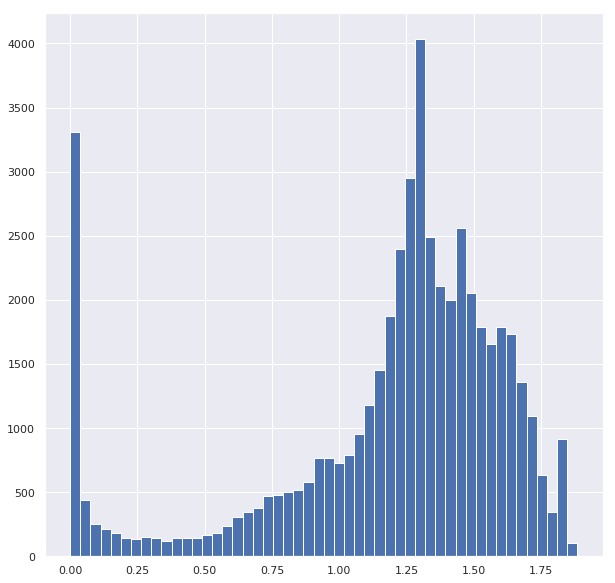

In [50]:
no_dup_data.l2.hist(bins=50)
# no_dup_data.l2.mean()

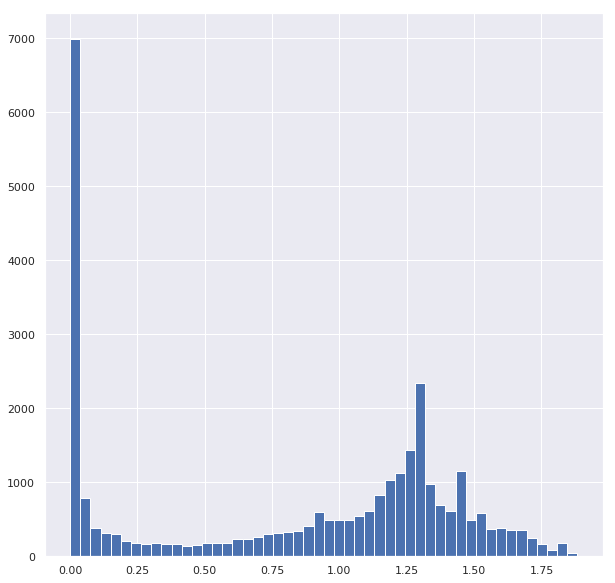

In [51]:
dup_data.l2.hist(bins=50)
# dup_data.l2.mean()

In [94]:
boundary = 0.7

In [ ]:
(len(dup_data[dup_data.l2<boundary]) + len(no_dup_data[no_dup_data.l2>=boundary]))/len(dev_data)